# ConvNet for image classification (CIFAR-10)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torch.utils.data import sampler

from pprint import pprint

%matplotlib inline

In [2]:
import sys

print('sys version: ', sys.version)
print('torch version: ', torch.version.__version__)

sys version:  3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
torch version:  0.4.1


In [3]:
EPOCHS = 16
PRINT_EVERY = 100

NUM_TRAIN = 49000
BATCH_SIZE = 64
CIFAR10_PATH = './cifar10_dataset'
DOWNLOAD = True

## Load CIFAR-10

In [4]:
# Set up a transform to preprocess the data by subtracting the mean RGB value 
# and dividing by the standard deviation of each RGB value;
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# Set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. 
# The CIFAR-10 training set is divided into train and val sets by passing a Sampler object
# to the DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10(CIFAR10_PATH, train=True, download=DOWNLOAD,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(CIFAR10_PATH, train=True, download=DOWNLOAD,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=BATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(CIFAR10_PATH, train=False, download=DOWNLOAD, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=BATCH_SIZE)

X_train = cifar10_train.train_data[:NUM_TRAIN]
y_train = cifar10_train.train_labels[:NUM_TRAIN]
X_val = cifar10_train.train_data[NUM_TRAIN:50000]
y_val = cifar10_train.train_labels[NUM_TRAIN:50000]
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

print(f'X_train: {X_train.shape}, [{X_train.min()}, {X_train.max()}]')
print(f'X_val: {X_val.shape}, [{X_val.min()}, {X_val.max()}]')
print(f'classes: {classes}')

X_train: (49000, 32, 32, 3), [0, 255]
X_val: (1000, 32, 32, 3), [0, 255]
classes: ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Look at some images

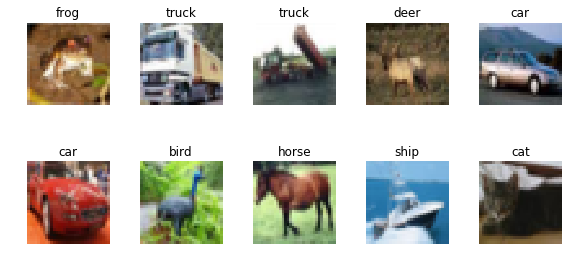

In [5]:
plt.figure(figsize=(8, 4))
batch = (X_train[0:10])

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch[i].astype('int32'))
    plt.axis('off')
    plt.title(classes[y_train[i]])

plt.tight_layout()

## ConvNet

In [6]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [7]:
in_channel = 3
channel_1 = 64
channel_2 = 16
num_classes = 10

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
def weights_init(m):
    if type(m) in [nn.Conv2d, nn.Linear]:
        #nn.init.normal_(m.weight.data, mean=0, std=0.1)
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias.data)

model = nn.Sequential(
    nn.Conv2d(in_channel, channel_1, (5, 5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(channel_1, channel_2, (5, 5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(channel_2 * 5 * 5, 200),
    nn.ReLU(),
    nn.Linear(200, num_classes)
)

model.apply(weights_init)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def check_accuracy(loader, model, dataset=None, print_acc=True):
    if loader.dataset.train and print_acc:
        if dataset is None:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on {} set'.format(dataset))
    elif print_acc:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device (GPU)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        if print_acc:
            print('Got %d / %d correct (%.2f%%)\n' % (num_correct, num_samples, 100 * acc))
    return 100 * acc


def train(model, optimizer, epochs=5, print_loss=True):
    val_acc = []
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    for e in range(epochs):
        print(f'epoch: {e}')
        if e % 5 == 0:
            weights[e] = []
            for i in range(len(model[0].weight)):
                weights[e].append(model[0].weight[i].clone())
        
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % PRINT_EVERY == 0:
                if print_loss:
                    print('Iteration %d, loss = %.4f' % (t, loss.item()))
                val_acc.append(check_accuracy(loader_val, model, print_acc=False))
            
    return val_acc

## Training

In [9]:
weights = {}
val_acc = train(model, optimizer, epochs=EPOCHS)

epoch: 0
Iteration 0, loss = 2.3032
Iteration 100, loss = 1.4869
Iteration 200, loss = 1.5545
Iteration 300, loss = 1.2916
Iteration 400, loss = 1.3204
Iteration 500, loss = 1.2202
Iteration 600, loss = 1.3831
Iteration 700, loss = 1.2417
epoch: 1
Iteration 0, loss = 1.0752
Iteration 100, loss = 1.2800
Iteration 200, loss = 1.1592
Iteration 300, loss = 1.0194
Iteration 400, loss = 0.9020
Iteration 500, loss = 1.3447
Iteration 600, loss = 1.1880
Iteration 700, loss = 1.2872
epoch: 2
Iteration 0, loss = 1.0570
Iteration 100, loss = 0.7280
Iteration 200, loss = 1.3616
Iteration 300, loss = 0.9306
Iteration 400, loss = 1.0341
Iteration 500, loss = 1.0712
Iteration 600, loss = 1.1954
Iteration 700, loss = 0.9596
epoch: 3
Iteration 0, loss = 0.8134
Iteration 100, loss = 0.8154
Iteration 200, loss = 1.0408
Iteration 300, loss = 1.0593
Iteration 400, loss = 1.1393
Iteration 500, loss = 0.9500
Iteration 600, loss = 0.8805
Iteration 700, loss = 0.8741
epoch: 4
Iteration 0, loss = 0.9571
Iteratio

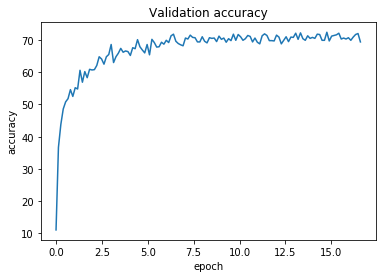

In [10]:
plt.figure()
plt.plot(np.arange(len(val_acc)) * BATCH_SIZE * PRINT_EVERY / (NUM_TRAIN), val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation accuracy')
plt.show()

## Results

In [11]:
check_accuracy(loader_train, model, dataset='train')
check_accuracy(loader_val, model)
check_accuracy(loader_test, model)

Checking accuracy on train set
Got 40912 / 49000 correct (83.49%)

Checking accuracy on validation set
Got 690 / 1000 correct (69.00%)

Checking accuracy on test set
Got 6742 / 10000 correct (67.42%)



67.42

## Searching the weights of the model :)

In [12]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=200, bias=True)
  (8): ReLU()
  (9): Linear(in_features=200, out_features=10, bias=True)
)


In [13]:
print(model[0])
print(model[0].weight.shape)

Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
torch.Size([64, 3, 5, 5])


## Final conv1 weights/filters

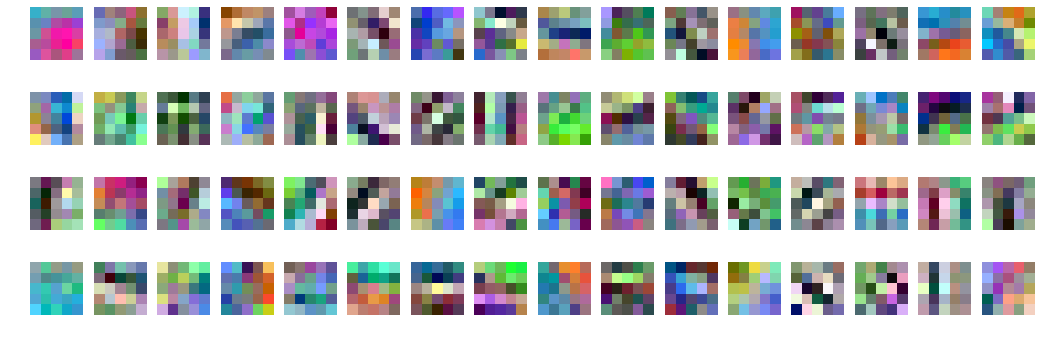

In [14]:
plt.figure(figsize=(18, 6))

num_weights = len(model[0].weight)
imgs_per_line = 16
for i in range(num_weights):
    plt.subplot(num_weights // imgs_per_line, imgs_per_line, i + 1)
    w = model[0].weight[i].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    w_min = w.min()
    w_max = w.max()
    w = (w - w_min) / (w_max - w_min)

    plt.imshow(w)
    plt.axis('off')

## Conv1 weights/filter during training

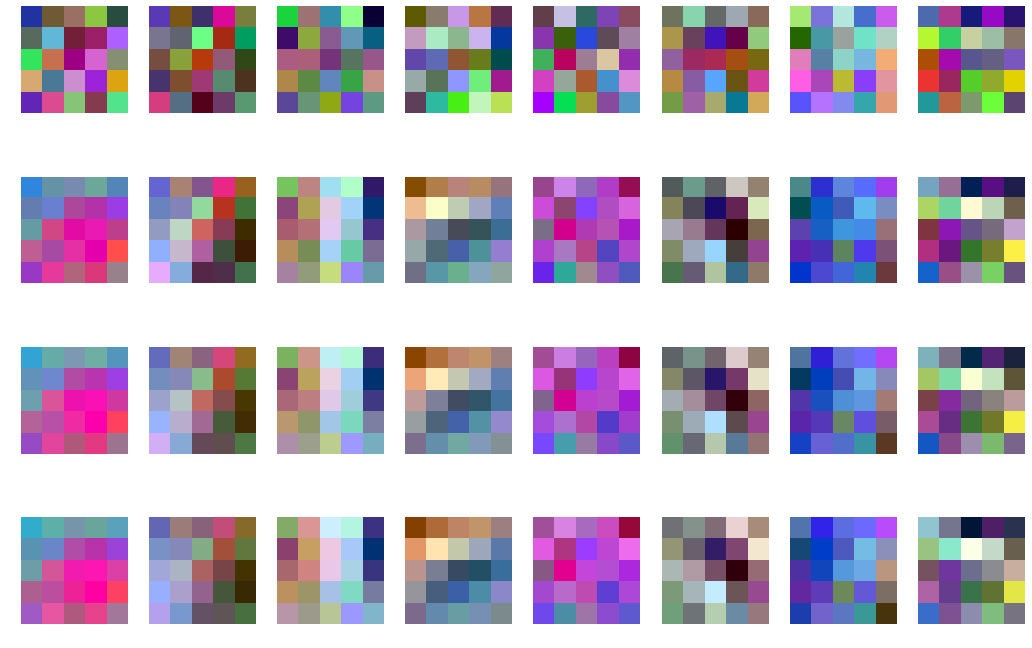

In [16]:
plt.figure(figsize=(18, 12))

imgs_per_line = 8
k = 0
for e in range(0, len(weights), 1):
    for i in range(imgs_per_line):
        k += 1
        plt.subplot(len(weights), imgs_per_line, k)
        w = weights[5*e][i].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
        w_min = w.min()
        w_max = w.max()
        w = (w - w_min) / (w_max - w_min)

        plt.imshow(w)
        plt.axis('off')